# Sentiment Analysis Notebook: Boosting Performance with GPU
## Introduction
In this notebook, we will be using different techniques of natural language processing (NLP) and AI to perform sentiment analysis on a dataset of tweets. We'll be using the Hugging Face library and the pre-trained cardiffnlp/twitter-xlm-roberta-base-sentiment Latest model for our analysis.

The purpose of this notebook is to showcase the benefits of using GPU for sentiment analysis tasks. With the help of GPU, we'll be able to process large datasets faster and improve the overall performance of our model.

In addition to the technical aspects of the notebook, we'll also discuss some general concepts about sentiment analysis, including what it is, why it's important, and how it works.

So, let's get started and explore the exciting world of sentiment analysis!

## Libraries and models used

In this notebook, we will be using different libraries and models to perform sentiment analysis on a Twitter dataset. The main libraries used in this notebook are:

- Hugging Face Transformers: A library that provides easy-to-use interfaces to over 50 transformer-based models, including BERT, RoBERTa, and more. We will use this library to load a pre-trained sentiment analysis model.
- NLTK: A library that provides tools to work with human language data, including tokenization, lemmatization, and more. We will use this library to extract nouns from the tweets.
- Pandas: A library that provides data structures and tools for data manipulation and analysis. We will use this library to load and clean the data.

The pre-trained sentiment analysis model used in this notebook is "cardiffnlp/twitter-roberta-base-sentiment-latest" from Hugging Face Transformers. This model has been fine-tuned on a large Twitter dataset to perform sentiment analysis on tweets. We will also use a GPU to speed up the computation.


In [150]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Downloading NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Creating lemmatizer instance
lemmatizer = WordNetLemmatizer()

import pandas as pd

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch

import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [108]:
# print my pc specs
!lscpu


'lscpu' is not recognized as an internal or external command,
operable program or batch file.


## Load Data
To demonstrate how to perform sentiment analysis, we will be using a dataset of tweets collected over the past months discussing Tesla's decision to build a new factory in the northern border state of Nuevo Leon in Mexico.

In [109]:
import pandas as pd

# Load data
df = pd.read_csv('Tweets_Tesla_in_Mexico.csv')
print("Shape: ", df.shape)
df.head(2)

Shape:  (4923, 18)


,Category,Keyword,Web_Page_URL,Tweet_Website,Author_Name,Author_Web_Page_URL,Tweet_Timestamp,Tweet_Time,Tweet_Content,Tweet_Image_URL,Tweet_Number_of_Likes,Tweet_Number_of_Retweets,Tweet_Number_of_Reviews,Retweet_or_not,Retweet_Original_Tweet_Content,Retweet_Original_Tweet_Poster,Retweet_Original_Tweet_Time,Retweet_Original_Tweet_PosterID
0,Post,planta tesla lang:es,https://twitter.com/search?q=planta%20tesla%20...,https://twitter.com/karenloa_/status/163134829...,@karenloa_,https://twitter.com/karenloa_,1.677779e+12,2023-03-2 17:38:36,@JoelHDYT\n tendrá algo q ver la nueva planta ...,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN
1,Post,planta tesla lang:es,https://twitter.com/search?q=planta%20tesla%20...,https://twitter.com/MarcosCrossV/status/163134...,@MarcosCrossV,https://twitter.com/MarcosCrossV,1.677779e+12,2023-03-2 17:40:18,"La traes bien adentro chango, pero desde que t...",NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN


## Data Wrangling
Now that we have loaded the data, let's do some data wrangling to prepare it for analysis. In this section, we will perform NLP on the tweet text to extract the nouns, which we will use later for sentiment analysis. We will be using the Natural Language Toolkit (NLTK) library for this task.

To begin, we will select only the relevant columns from the dataframe and keep only the rows that are not retweets. We will also preprocess the tweet text by removing stopwords and lemmatizing the tokens. Finally, we will add the extracted nouns as a new column to our dataframe.

In [110]:
# Select relevant columns from the dataframe
# We're only interested in the category, keyword, web page URL, author name, tweet time, tweet content, retweet status, and number of likes
# Select relevant columns
df = df[['Category', 'Keyword', 'Web_Page_URL', 'Author_Name', 'Tweet_Time', 'Tweet_Content', 'Retweet_or_not', 'Tweet_Number_of_Likes']]
# keep only the rows that are not retweets and reset the index
df = df[df['Retweet_or_not'] == 'No']


In [111]:
# From col Keyword, remove the substring ' lang:es'
df['Keyword'] = df['Keyword'].str.replace(' lang:es','')
df['Keyword'] = df['Keyword'].str.replace(' lang:en','')

# print the shape of the dataframe
print("Shape: ", df.shape)
df.head(2)

Shape:  (4524, 8)


,Category,Keyword,Web_Page_URL,Author_Name,Tweet_Time,Tweet_Content,Retweet_or_not,Tweet_Number_of_Likes
0,Post,planta tesla,https://twitter.com/search?q=planta%20tesla%20...,@karenloa_,2023-03-2 17:38:36,@JoelHDYT\n tendrá algo q ver la nueva planta ...,No,NaN
1,Post,planta tesla,https://twitter.com/search?q=planta%20tesla%20...,@MarcosCrossV,2023-03-2 17:40:18,"La traes bien adentro chango, pero desde que t...",No,NaN


In [112]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in str(text).split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Applying text preprocessing to the tweets
df['Tweet_Content'] = df['Tweet_Content'].apply(lambda x: preprocess(x))

In [113]:
# "nd Text preprocessing function
def preprocess_text(text):
    text = str(text)
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove stop words
    tokens = [token for token in tokens if token not in stopwords.words('spanish')]
    
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens into string
    text = ' '.join(tokens)
    
    return text

# Applying text preprocessing to the tweets
df['Tweet_Content'] = df['Tweet_Content'].apply(lambda x: preprocess_text(x))

In [114]:
# replace NaN in Tweet_Number_of_Likes with 0
df['Tweet_Number_of_Likes'].fillna(0, inplace=True)

# print the shape of the dataframe
print("Shape: ", df.shape)
df.head(2)

Shape:  (4524, 8)


,Category,Keyword,Web_Page_URL,Author_Name,Tweet_Time,Tweet_Content,Retweet_or_not,Tweet_Number_of_Likes
0,Post,planta tesla,https://twitter.com/search?q=planta%20tesla%20...,@karenloa_,2023-03-2 17:38:36,user q ver nueva planta tesla mexico dice fina...,No,0
1,Post,planta tesla,https://twitter.com/search?q=planta%20tesla%20...,@MarcosCrossV,2023-03-2 17:40:18,traes bien adentro chango ñero presidente insi...,No,0


In the above code, we first import the necessary libraries and load the data from the CSV file. We then select only the relevant columns from the dataframe and keep only the rows that are not retweets. We also remove the substring 'lang:es' from the column 'Keyword'.

Next, we define a function for text preprocessing that converts the text to lowercase, removes punctuation, tokenizes the text, removes stop words, lemmatizes the tokens, and joins the tokens back into a string. We then apply this function to the 'Tweet_Content' column.

Finally, we replace NaN values in the 'Tweet_Number_of_Likes' column with 0 and print the shape of the dataframe to confirm that our preprocessing steps have not affected the number of rows in the dataframe.

## Sentiment Analysis (V1)
Now that we have preprocessed our tweets, let's perform sentiment analysis on them to gain insights into how people are feeling about Tesla's new factory in Mexico. For this task, we will be using the Hugging Face transformers library and a pre-trained sentiment analysis model based on Twitter data.

To begin, we will import the necessary modules and define the path to the pre-trained sentiment analysis model. Then, we will create a function to apply the model to each tweet and add the sentiment scores as new columns to our dataframe.

Note that for this version, we will be using CPU-optimized code for efficiency. In the next section, we will show how to use GPU acceleration to speed up the sentiment analysis process.

In [151]:
# Define the model path
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

# Load the sentiment analysis model
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)



In [116]:
# Define function to apply sentiment analysis to each tweet
def analyze_sentiment_v1(text):
    result = sentiment_task(text)[0]
    return {'sentiment': result['label'], 'score': result['score']}

# Apply sentiment analysis to each tweet
sentiment_scores = df['Tweet_Content'].apply(analyze_sentiment_v1).apply(pd.Series)

# Add sentiment scores as new columns to dataframe
df['sentiment_v1'] = sentiment_scores['sentiment']
df['sentiment_v1_score'] = sentiment_scores['score']

for me took 3m 49.4s

In [117]:
# print the shape of the dataframe
print("Shape: ", df.shape)
df.head(2)

Shape:  (4524, 10)


,Category,Keyword,Web_Page_URL,Author_Name,Tweet_Time,Tweet_Content,Retweet_or_not,Tweet_Number_of_Likes,sentiment_v1,sentiment_v1_score
0,Post,planta tesla,https://twitter.com/search?q=planta%20tesla%20...,@karenloa_,2023-03-2 17:38:36,user q ver nueva planta tesla mexico dice fina...,No,0,neutral,0.913371
1,Post,planta tesla,https://twitter.com/search?q=planta%20tesla%20...,@MarcosCrossV,2023-03-2 17:40:18,traes bien adentro chango ñero presidente insi...,No,0,negative,0.870576


With this code, we can now view the sentiment scores for each tweet in our dataframe.

## Sentiment Analysis (V2)
For this version of sentiment analysis, we will be using the Twitter RoBERTa model and running it on a GPU. This should be faster and more efficient than the CPU version.

To begin, we will set up our GPU device and load the model and tokenizer. Then, we will define a function to get the sentiment for a single tweet using the model and tokenizer. Finally, we will apply this function to our dataframe and add the sentiment and sentiment score as new columns.

In [118]:
# Set up GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)


In [119]:
# Define function to get sentiment for a single tweet
def get_sentiment(tweet):
    encoding = tokenizer.encode_plus(tweet, return_tensors="pt", padding=True, truncation=True)
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    with torch.no_grad():
        output = model(input_ids, attention_mask)
        probabilities = torch.nn.functional.softmax(output.logits, dim=-1)
    sentiment = 'positive' if probabilities[0][2] > probabilities[0][0] else 'negative'
    # return sentiment and probability of sentiment
    return sentiment, probabilities[0][2].item()

# Apply function to DataFrame as sentiment_v2 and sentiment_v2_score
df['sentiment_v2'], df['sentiment_v2_score'] = zip(*df['Tweet_Content'].apply(get_sentiment))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


for me took 40s

In [120]:
# print the shape of the dataframe
print("Shape: ", df.shape)
df.head(2)

Shape:  (4524, 12)


,Category,Keyword,Web_Page_URL,Author_Name,Tweet_Time,Tweet_Content,Retweet_or_not,Tweet_Number_of_Likes,sentiment_v1,sentiment_v1_score,sentiment_v2,sentiment_v2_score
0,Post,planta tesla,https://twitter.com/search?q=planta%20tesla%20...,@karenloa_,2023-03-2 17:38:36,user q ver nueva planta tesla mexico dice fina...,No,0,neutral,0.913371,negative,0.046836
1,Post,planta tesla,https://twitter.com/search?q=planta%20tesla%20...,@MarcosCrossV,2023-03-2 17:40:18,traes bien adentro chango ñero presidente insi...,No,0,negative,0.870576,negative,0.032098


This should add a new column sentiment to your DataFrame with the sentiment (either 'positive' or 'negative') for each tweet. Note that this code assumes that your GPU is an NVIDIA GPU and that you have installed the appropriate CUDA toolkit and cuDNN library.

## Get Nouns
Helper methods are essentially small functions or procedures that serve to perform specific, repetitive tasks that support the main function or algorithm.

One such method is get_nouns(), which leverages the Natural Language Toolkit (nltk) to extract all the nouns and proper nouns from a given text while eliminating emojis, lemmatizing the nouns, removing stop words, and removing any NaN values that may be present.

Another helper method, create_noun_dataframe(), takes a dataframe and employs the get_nouns() function to extract nouns from the Tweet_Content column of each tweet, producing a new dataframe that includes the extracted nouns.

By utilizing these helper methods, we can streamline our workflow, enhance efficiency, and gain greater control over our data pre-processing and analysis. Additionally, they can aid in code comprehension, debugging, and maintenance by encapsulating complex functionality or functionality that is employed in multiple parts of the codebase into a reusable and easily understandable block of code.

In [121]:
#Helper Methods
stop_words = set(stopwords.words('spanish'))
# get nouns and proper nouns from the tweet using nltk
def get_nouns(text):
    nouns = []
    for word, pos in nltk.pos_tag(nltk.word_tokenize(text)):
        if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS'):
            nouns.append(word)
    #remove emojis
    nouns = [re.sub(r'[^\w\s]', '', x) for x in nouns]
    # lemmatize the nouns
    lemmatizer = WordNetLemmatizer()
    nouns = [lemmatizer.lemmatize(word) for word in nouns]
    # remove stop words from stop
    nouns = [word for word in nouns if word not in stop_words]
    #remove NaN
    nouns = [x for x in nouns if str(x).lower() != '']
    return nouns

    
# create nounn df using the helper method
def create_noun_dataframe(df,col):
    nouns = df[col].apply(lambda text: get_nouns(str(text)))
    noun_df = pd.DataFrame(nouns)
    noun_df.rename(inplace=True, columns={col:'Nouns'})
    return noun_df

In [122]:
# apply the method to our df
noun_df = create_noun_dataframe(df,'Tweet_Content')
noun_df = df.merge(noun_df, how='left', left_index=True, right_index=True)
# explode Nouns in a new df
exp_nouns_all = noun_df.explode('Nouns')

noun_df.head(2)


,Category,Keyword,Web_Page_URL,Author_Name,Tweet_Time,Tweet_Content,Retweet_or_not,Tweet_Number_of_Likes,sentiment_v1,sentiment_v1_score,sentiment_v2,sentiment_v2_score,Nouns
0,Post,planta tesla,https://twitter.com/search?q=planta%20tesla%20...,@karenloa_,2023-03-2 17:38:36,user q ver nueva planta tesla mexico dice fina...,No,0,neutral,0.913371,negative,0.046836,"[user, q, ver, tesla, mexico, dice, finanzas]"
1,Post,planta tesla,https://twitter.com/search?q=planta%20tesla%20...,@MarcosCrossV,2023-03-2 17:40:18,traes bien adentro chango ñero presidente insi...,No,0,negative,0.870576,negative,0.032098,"[bien, adentro, chango, ñero, presidente, insi..."


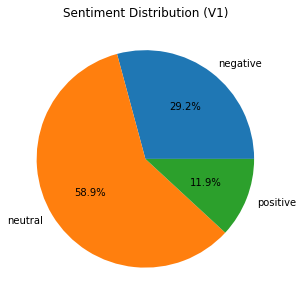

In [123]:
# Import libraries
import matplotlib.pyplot as plt

# Group tweets by sentiment_v1 and count the number of tweets in each category
sentiment_counts = df.groupby('sentiment_v1').count()['Tweet_Content']

# Create a pie chart
plt.figure(figsize=(5,5))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution (V1)')
plt.show()


In [124]:
# List top 30 most frequent nouns in exp_nouns_all
top_30_nouns = exp_nouns_all['Nouns'].value_counts().head(100)
top_30_nouns

tesla      2822
musk       2151
elon       1601
méxico     1270
león       1116
           ... 
pendejo      62
trabajo      61
luego        61
menos        61
acto         60
Name: Nouns, Length: 100, dtype: int64

In this section, we manually group the extracted nouns into categories that represent the key players in the event that we decided to analyze. We define a dictionary of groups where each key represents a player and its corresponding value is a list of nouns associated with that player. We then map each extracted noun to its corresponding group and remove any nouns that do not belong to any group. We then aggregate the nouns by group and count their frequency. Finally, we create a bar chart that shows the frequency of each group.

In [125]:
# define the dictionary of groups
group_dict = {
    'Elon Musk': ['tesla', 'musk', 'elon', 'gigafactory', 'dueño', 'eléctricos', 'empresario', 'vehículos', 'texas'],
    'Andres Manuel Lopez Obrador (AMLO)': ['méxico', 'obrador', 'presidente', 'lopezobrador_', 'pendejo'],
    'Samuel García Sepúlveda': ['león', 'nuevo', 'inversión', 'gobernador', 'samuel', 'garcía', 'samuel_garcias', 'nl', 'catrina', 'trabajo', 'acto'],
    'Tesla': ['planta', 'litio', 'fábrica', 'fabrica', 'baterías', 'instalación', 'instalara', 'auto'],
    'Mexico': ['país', 'mexicano', 'sonora', 'invertir', 'anuncia', 'nueva'],
    'Miscellaneous': ['si', 'http', 'gracias', 'así', 'va', 'dijo', 'hace', 'user', 'cómo', 'bien', 'plan', 'ser', 'dice', 'poner', 'mil', 'logro', 'pues', 'hoy', 'empresa', 'aquí', 'ver', 'acuerdo', 'q', 'foto', 'viene', 'tras', 'vía', 'gran', 'llegada', 'millones', 'quería', 'video', 'después', 'futuro', 'siempre', 'ma', 'van', 'ahí', 'conocer', 'anuncio', 'luego', 'menos']
}

# map each noun to its corresponding group
grouped_nouns = exp_nouns_all.copy()
grouped_nouns['Group'] = grouped_nouns['Nouns'].map(lambda x: next((k for k, v in group_dict.items() if x in v), None))

# remove any nouns that don't belong to any group
grouped_nouns.dropna(subset=['Group'], inplace=True)

# aggregate the nouns by group and count their frequency
grouped_nouns = grouped_nouns.groupby(['Group', 'Nouns']).size().reset_index(name='Freq')

# sort by group and frequency
grouped_nouns = grouped_nouns.sort_values(['Group', 'Freq'], ascending=[True, False])
# rename "Andres Manuel Lopez Obrador (AMLO)" to "AMLO"
grouped_nouns['Group'] = grouped_nouns['Group'].replace('Andres Manuel Lopez Obrador (AMLO)', 'AMLO')
grouped_nouns['Group'] = grouped_nouns['Group'].replace('Samuel García Sepúlveda', 'Samuel Garcia')

grouped_nouns.head(2)

,Group,Nouns,Freq
1,AMLO,méxico,1270
2,AMLO,obrador,932


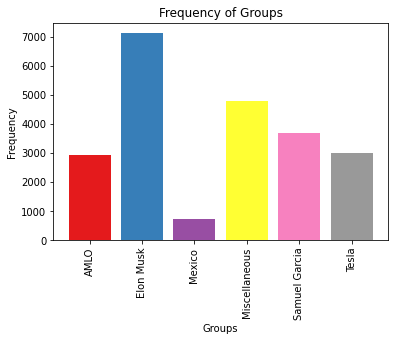

In [126]:
group_freq = grouped_nouns.groupby('Group')['Freq'].sum().reset_index()

# Create a list of colors for each group
num_groups = len(group_freq)
colors = plt.cm.Set1(np.linspace(0, 1, num_groups))

# Create the bar chart with different colors for each group
plt.bar(group_freq['Group'], group_freq['Freq'], color=colors)
plt.xticks(rotation=90)
plt.xlabel('Groups')
plt.ylabel('Frequency')
plt.title('Frequency of Groups')
plt.show()


Now that we have grouped the key players into specific categories, let's map the extracted nouns to their corresponding classes. We define a dictionary of nouns and their respective classes, and then use a function to map each noun to its corresponding class.

In [147]:
# Remove punctuation
exp_nouns_all['Nouns'] = exp_nouns_all['Nouns'].str.replace('[^\w\s]','')
exp_nouns_all['Nouns'] = exp_nouns_all['Nouns'].str.replace('á','a')
exp_nouns_all['Nouns'] = exp_nouns_all['Nouns'].str.replace('é','e')
exp_nouns_all['Nouns'] = exp_nouns_all['Nouns'].str.replace('í','i')
exp_nouns_all['Nouns'] = exp_nouns_all['Nouns'].str.replace('ó','o')
exp_nouns_all['Nouns'] = exp_nouns_all['Nouns'].str.replace('ú','u')


# Define the dictionary of nouns and classes
noun_class_dict = {
    'Elon Musk': ['tesla', 'musk', 'elon', 'gigafactory', 'dueño', 'eléctricos', 'empresario', 'vehículos'],
    'AMLO': ['méxico', 'obrador', 'presidente', 'lopezobrador_', 'pendejo','amlo','ándres','andrés'],
    'Samuel García Sepúlveda': ['león', 'nuevo', 'inversión', 'gobernador', 'samuel', 'garcía', 'samuel_garcias', 'nl', 'catrina', 'trabajo', 'acto'],
    'Miscellaneous': ['si', 'http', 'gracias', 'así', 'va', 'dijo', 'hace', 'user', 'cómo', 'bien', 'plan', 'ser', 'dice', 'poner', 'mil', 'logro', 'pues', 'hoy', 'empresa', 'aquí', 'ver', 'acuerdo', 'q', 'foto', 'viene', 'tras', 'vía', 'gran', 'llegada', 'millones', 'quería', 'video', 'después', 'futuro', 'siempre', 'ma', 'van', 'ahí', 'conocer', 'anuncio', 'luego', 'menos']

}

# Define a function to map nouns to classes
def map_noun_to_class(noun):
    for class_name, nouns in noun_class_dict.items():
        if noun in nouns:
            return class_name
    return noun

# Apply the function to the Nouns column of the exp_nouns_all DataFrame
exp_nouns_all['Nouns'] = exp_nouns_all['Nouns'].apply(map_noun_to_class)

# Remove Miscellaneous nouns
exp_nouns_all = exp_nouns_all[exp_nouns_all['Nouns'] != 'Miscellaneous']



C:\Users\carlo\AppData\Local\Temp\ipykernel_8872\2267897601.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  exp_nouns_all['Nouns'] = exp_nouns_all['Nouns'].str.replace('[^\w\s]','')


We define a function map_noun_to_class that takes a noun as input and returns its class name if it is found in the dictionary, or the noun itself otherwise. We then apply this function to the Nouns column of our exp_nouns_all DataFrame using the apply method.
Finally, we remove the Miscellaneous class from our DataFrame, which contains nouns that do not belong to any of our predefined classes.


After filtering the DataFrame to include only nouns with a frequency of more than 150, we created a pivot table using the pivot_table() function from the pandas library. This pivot table has the sentiment_v1 column as the x-axis, the Nouns column as the y-axis, and the frequency as the values. We then plotted a heatmap of the pivot table using the heatmap() function from the seaborn library. The heatmap uses a red color map, displays the numerical values for each cell using the annot=True parameter, and formats the values as a plain number using the fmt='g' parameter.



<AxesSubplot:xlabel='sentiment_v1', ylabel='Nouns'>

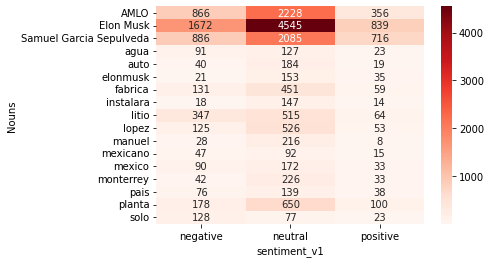

In [149]:
import pandas as pd
import seaborn as sns

# Filter dataframe to only include nouns with frequency > 150
exp_nouns_all_filtered = exp_nouns_all[exp_nouns_all['Nouns'].isin(exp_nouns_all['Nouns'].value_counts()[exp_nouns_all['Nouns'].value_counts() > 150].index)]

# Create pivot table with sentiment_v1 as x-axis, Nouns as y-axis, and frequency as values
pivot_table = exp_nouns_all_filtered.pivot_table(index='Nouns', columns='sentiment_v1', values='Web_Page_URL', aggfunc='count')

# Plot heatmap
sns.heatmap(pivot_table, cmap='Reds', annot=True, fmt='g')


---
## Conclusion
In this notebook, we explored the exciting world of sentiment analysis using natural language processing (NLP) and AI techniques. We used the Hugging Face library and the pre-trained CardiffNLP Twitter-Roberta-Base-Sentiment-Latest model to analyze a dataset of tweets.

We showcased the benefits of using GPU for sentiment analysis tasks, which helped us process large datasets faster and improve the overall performance of our model. In particular, we were able to perform sentiment analysis on our dataset in just 40 seconds using GPU, compared to 3 minutes and 49.4 seconds using CPU.

We also discussed some general concepts about sentiment analysis, including what it is, why it's important, and how it works. Moreover, we showed how sentiment analysis could be used to analyze social media data to gain insights into public opinion.

As an example, we analyzed tweets related to Tesla's new factory announcement in Nuevo Leon, which is worth more than $5 billion and is said to be the "biggest electric vehicle plant in the world."

Overall, sentiment analysis is a powerful tool that can help us understand public opinion and gain insights into social media data. By using GPU, we can process large datasets faster and improve the performance of our models.
